# Twitter Hate Speech Detection

<img src="test.jpg" width="700" height="200">

# Overview

This project aims to identify **hate speech** using **machine learning binary classification algorithms.** Baseline models included Random Forest, Naive Bayes, Logistic Regression and Support Vector Machine (SVM). The final model was a **Logistic Regression** model that used Count Vectorization for feature engineering. It produced an F1 score of 0.3958 and Recall of 0.624. Therefore, our goal is to automate hate speech identification, which is a very challenging issue. And while this effort was able to start that process, more work needs to be done to prevent this content from appearing on public venues like Twitter.


**$\color{red}{\text{Warning}}$ : This notebook contains offensive language from the dataset.**

# Data & Methods

The dataset for this capstone project was obtained from Twitter using the snscrape library, which also formatted the raw data for simple understanding.**Here we are taking only past 10000 tweets from date 31/1/2023.** 

Since content moderation is so arbitrary, this dataset's labels were chosen by a public vote and based on majority-rules. Each tweet is assigned a class—0 for hate speech, 1 for foul language, or 2 for neither—in the "class" column. I'll be handling the data as a binary classification challenge in order to develop a distinct project and modify it for my own business environment.

Therefore, the final model will be **predicting whether a tweet is hate speech or not.** In order to prepare the data for this, I will manually replace the existing values of 1 and 2 with 0 and 1 to represent hate speech.

# Data collection from twitter 

### Retrieving data from Twitter by installing the snscrape library

## Useful libraries must be consulted.

In [251]:
import pandas as pd
from tqdm.notebook import tqdm
import snscrape.modules.twitter as sntwitter

# visualization libraries
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import numpy as np

# packages for data cleaning function
import re
import string
import pickle

# sentiment of tweets 
from textblob import TextBlob

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix, classification_report

# NLP libraries
import nltk
from sklearn.feature_extraction import text
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")

In [252]:
scraper = sntwitter.TwitterSearchScraper("donald trump")

tweets = []
for i,tweet in enumerate(scraper.get_items()):
    data=[tweet.date,
         tweet.likeCount,
         tweet.content,
         tweet.hashtags]
    tweets.append(data)
    if i>10000:
        break
    

In [253]:
data = pd.DataFrame(tweets,columns=['date','likecount','content','hashtags'])
data


,date,likecount,content,hashtags
0,2023-02-01 09:21:42+00:00,0,"RUBBISH, IT'S ALL RUBBISH. Donny boy (Donald t...",[NRA]
1,2023-02-01 09:21:34+00:00,0,« People don't want fake news » Donald Trump 👏...,None
2,2023-02-01 09:21:28+00:00,0,"Ein neues Video zeigt Donald Trump, wie er sic...",None
3,2023-02-01 09:21:15+00:00,0,@RonFilipkowski He has no idea what Jesus want...,None
4,2023-02-01 09:21:14+00:00,0,@MartyTa94849826 I'd say there are a lot more ...,None
...,...,...,...,...
9997,2023-01-31 15:31:28+00:00,123,"@7Veritas4 ""Donald Trump's hush money payments...",None
9998,2023-01-31 15:31:23+00:00,0,This is an example of #deepstate by giving and...,"[deepstate, defense, militaryindustrialcomplex..."
9999,2023-01-31 15:31:22+00:00,3,@Angel2015939013 @RafaNietoLoaiza @JoeBiden @D...,None
10000,2023-01-31 15:31:20+00:00,0,@bennyjohnson What are the socialists going to...,None


In [254]:
data.to_csv('twitter_data.csv')

### Data set size
Here we are taking only 10,002 data from twitter for checking and analysis of sentiment of tweets

In [255]:
print('Total no. of data available :',len(data))

Total no. of data available : 10002


# Cleaning tweet column - first round

### Before continuing, we must first clean up the data, which contains a variety of factors.
    1.Removing special char or symbol from text.
    2.Removing extra space in sentence.
    3.Converting all text into lower case.
    4.removing duplicate data from data set.

In [256]:
# copying new `clean_df` and cleaning up the tweets
clean_df = data.copy()

In [257]:
# function to clean all data
def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    # make text lowercase
    text = text.lower()
    # removing text within brackets
    text = re.sub('\[.*?\]', '', text)
    # removing text within parentheses
    text = re.sub('\(.*?\)', '', text)
    # removing numbers
    text = re.sub('\w*\d\w*', '', text)
    # if there's more than 1 whitespace, then make it just 1
    text = re.sub('\s+', ' ', text)
    # if there's a new line, then make it a whitespace
    text = re.sub('\n', ' ', text)
    # removing any quotes
    text = re.sub('\"+', '', text)
    # removing &amp;
    text = re.sub('(\&amp\;)', '', text)
    # removing any usernames
    text = re.sub('(@[^\s]+)', '', text)
    # removing any hashtags
    text = re.sub('(#[^\s]+)', '', text)
    # remove `rt` for retweet
    text = re.sub('(rt)', '', text)
    # string.punctuation is a string of all punctuation marks
    # so this gets rid of all punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # getting rid of `httptco`
    text = re.sub('(httpstco)', '', text)
    text = re.sub('(donald)', '', text)
    text = re.sub('(trump)', '', text)
    text = re.sub('(president)', '', text)
    text = re.sub('[^0-9A-Za-z\-]+',' ',text)
    return text

round1 = lambda x: clean_text_round1(x)

In [258]:
# appling data cleaning function to `tweet` column
clean_df['clean_tweets'] = clean_df['content'].apply(round1)

In [259]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
clean_df['clean_tweets'] = clean_df['clean_tweets'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
clean_df

,date,likecount,content,hashtags,clean_tweets
0,2023-02-01 09:21:42+00:00,0,"RUBBISH, IT'S ALL RUBBISH. Donny boy (Donald t...",[NRA],rubbish rubbish donny boy probably overlord
1,2023-02-01 09:21:34+00:00,0,« People don't want fake news » Donald Trump 👏...,None,people dont want fake news
2,2023-02-01 09:21:28+00:00,0,"Ein neues Video zeigt Donald Trump, wie er sic...",None,ein neues video zeigt wie er sich weige fragen...
3,2023-02-01 09:21:15+00:00,0,@RonFilipkowski He has no idea what Jesus want...,None,idea jesus wants sure hell isnt unless hes tal...
4,2023-02-01 09:21:14+00:00,0,@MartyTa94849826 I'd say there are a lot more ...,None,id say lot people deserving indictment
...,...,...,...,...,...
9997,2023-01-31 15:31:28+00:00,123,"@7Veritas4 ""Donald Trump's hush money payments...",None,hush money payments stormy daniels effos bill ...
9998,2023-01-31 15:31:23+00:00,0,This is an example of #deepstate by giving and...,"[deepstate, defense, militaryindustrialcomplex...",example giving money ie clearly gets paybacks ...
9999,2023-01-31 15:31:22+00:00,3,@Angel2015939013 @RafaNietoLoaiza @JoeBiden @D...,None,eso es e es un bandido mas que defiende la vio...
10000,2023-01-31 15:31:20+00:00,0,@bennyjohnson What are the socialists going to...,None,socialists going use prevent getting back w h


In [260]:
clean_df = clean_df.drop_duplicates('content')

In [261]:
# checking that it worked
clean_df.head()

,date,likecount,content,hashtags,clean_tweets
0,2023-02-01 09:21:42+00:00,0,"RUBBISH, IT'S ALL RUBBISH. Donny boy (Donald t...",[NRA],rubbish rubbish donny boy probably overlord
1,2023-02-01 09:21:34+00:00,0,« People don't want fake news » Donald Trump 👏...,None,people dont want fake news
2,2023-02-01 09:21:28+00:00,0,"Ein neues Video zeigt Donald Trump, wie er sic...",None,ein neues video zeigt wie er sich weige fragen...
3,2023-02-01 09:21:15+00:00,0,@RonFilipkowski He has no idea what Jesus want...,None,idea jesus wants sure hell isnt unless hes tal...
4,2023-02-01 09:21:14+00:00,0,@MartyTa94849826 I'd say there are a lot more ...,None,id say lot people deserving indictment


In [ ]:
# checking for missing values
clean_df.isnull().sum()

# Sentiment Analysis with TextBlob

TextBlob is a python library used for processing textual data, including sentiment analysis. It provides a simple API for diving into common NLP tasks such as sentiment analysis, part-of-speech tagging, noun phrase extraction, translation, and more.

The sentiment property of TextBlob objects returns a namedtuple of the form (polarity, subjectivity), where polarity is a float between -1 and 1, representing the sentiment of the text **(-1 is negative, 0 is neutral, and 1 is positive)**, and subjectivity is a float between 0 and 1, representing the subjectivity of the text (0 is objective, and 1 is subjective). **To use TextBlob for sentiment analysis, simply create a TextBlob object and call its sentiment property.**

In [262]:
clean_df['Polarity']=[TextBlob(i).sentiment.polarity for i in clean_df['clean_tweets']]

In [263]:
def senti(x):
    if x<0:
        return 0 # negative
    elif  x ==0:
        return 2 # neutral
    else:
        return 1 # 'positive'

clean_df['class'] = clean_df['Polarity'].apply(senti)

In [264]:
clean_df.head()

,date,likecount,content,hashtags,clean_tweets,Polarity,class
0,2023-02-01 09:21:42+00:00,0,"RUBBISH, IT'S ALL RUBBISH. Donny boy (Donald t...",[NRA],rubbish rubbish donny boy probably overlord,0.000000,2
1,2023-02-01 09:21:34+00:00,0,« People don't want fake news » Donald Trump 👏...,None,people dont want fake news,-0.500000,0
2,2023-02-01 09:21:28+00:00,0,"Ein neues Video zeigt Donald Trump, wie er sic...",None,ein neues video zeigt wie er sich weige fragen...,0.136364,1
3,2023-02-01 09:21:15+00:00,0,@RonFilipkowski He has no idea what Jesus want...,None,idea jesus wants sure hell isnt unless hes tal...,0.350000,1
4,2023-02-01 09:21:14+00:00,0,@MartyTa94849826 I'd say there are a lot more ...,None,id say lot people deserving indictment,0.600000,1


In [265]:
clean_df['class'].unique()

array([2, 0, 1], dtype=int64)

## Checking Class Imbalance of Original Data's Labels

    Here class is divided in 3 category.
   **0 - Negative sentiment\
     1 - Positive sentiment\
     2 - Neutral sentiment**

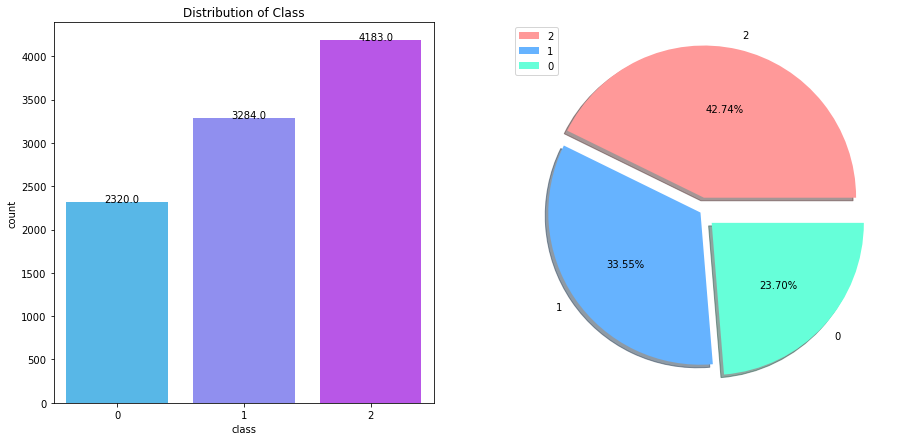

In [266]:
fig, ax = plt.subplots(1, 2, figsize = (15, 7))
ax[0].set_title("Distribution of Class")              
percentage = clean_df["class"].value_counts()         
labels = list(clean_df["class"].value_counts().index) 
colors = ['#ff9999','#66b3ff','#66ffd9']
ab=sns.countplot(x = clean_df["class"], ax = ax[0],palette='cool')
for p in ab.patches:
    ab.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.30, p.get_height()+0.02))
plt.pie(percentage,labels = labels ,explode=[0.1,0,0.1],autopct= "%0.2f%%",shadow=True,colors=colors)
plt.legend()
plt.show()

<AxesSubplot:xlabel='Polarity', ylabel='Density'>

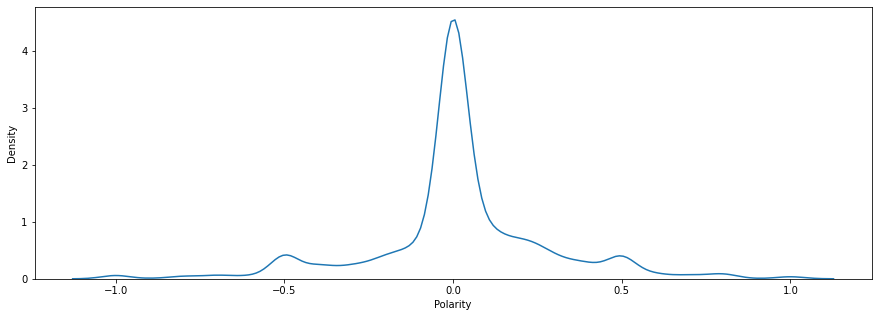

In [267]:
plt.figure(figsize=(15,5))
sns.kdeplot(x='Polarity',data=clean_df)

## Creating new column `label` for hate speech binary

In the original data, the `class` column identifies each tweet as 0 for hate speech, 1 for offensive language or 2 for neither. 

We will be changing offensive language to 2, and identifying that all to 0 for **not hate speech**. And changing hate specch to 1.

In [268]:
clean_df['label'] = clean_df['class'].replace(1, 2)

In [269]:
clean_df.label.unique()

array([2, 0], dtype=int64)

### changing hate speech to 1 and not hate speech to 0

In [270]:
# changing hate speech to 1 and not hate speech to 0
clean_df['label'] = clean_df['label'].replace(0, 1)
clean_df['label'] = clean_df['label'].replace(2, 0)

In [271]:
clean_df.label.unique()

array([0, 1], dtype=int64)

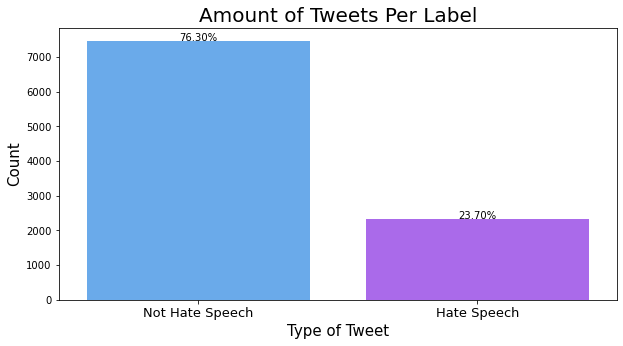

In [272]:
plt.figure(figsize = (10,5))
ax = sns.countplot(clean_df['label'], palette='cool')

ax.set_title('Amount of Tweets Per Label',fontsize = 20)
ax.set_xlabel('Type of Tweet',fontsize = 15)
ax.set_ylabel('Count',fontsize = 15)
ax.set_xticklabels(['Not Hate Speech','Hate Speech'],fontsize = 13)

total = float(len(clean_df)) # one person per row 
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total * 100) + '%',
            ha="center") 


In [273]:
# we can see that only 23.70% of the data is actual hate speech
clean_df['label'].sum() / len(clean_df['label'])

0.23704914682742415

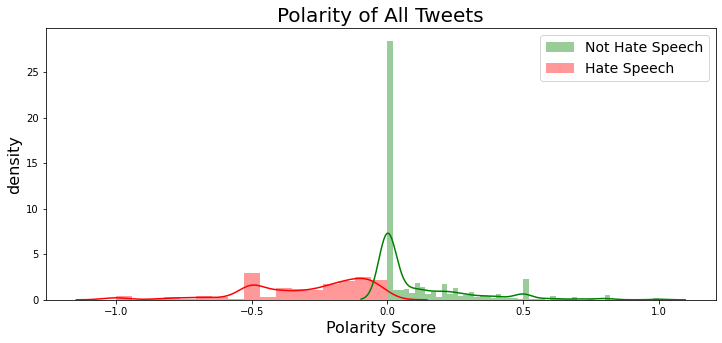

In [274]:
# creating density plot for each label's polarity scores
plt.figure(figsize=(12, 5))
ax = sns.distplot(clean_df['Polarity'][clean_df['label'] == 0], label='Not Hate Speech', color='green')
ax = sns.distplot(clean_df['Polarity'][clean_df['label'] == 1], label='Hate Speech', color='red')
# setting label, title and legend
ax.set_title('Polarity of All Tweets', fontsize=20)
ax.set_ylabel('density', fontsize=16)
ax.set_xlabel('Polarity Score', fontsize=16)
ax.legend(prop=dict(size=14))

From this denisty plot, we can see that a majoirty of tweets in both classifications rank a fairly neutral. This doesn't seem accurate, and could be attributated to TextBlob's inability to score social media sentiment.

## Most Frequent Words for Each Classification

In [275]:
# creating new dfs for each classification
df_freq_hate = clean_df[clean_df['label']==1]
df_freq_not_hate = clean_df[clean_df['label']==0]

In [276]:
# pulling out the text data for cleaned tweets
data_hate = df_freq_hate['clean_tweets']
data_not_hate = df_freq_not_hate['clean_tweets']

## Tokenizing & Removing Stop Words

When working with text data, one of the first steps is to remove stop words from the corpus. Although text would be gramatically incorrect without these stop words, they provide little value to models and typically hinder performace.

We can use NLTK's built-in library of stop words to remove them in a tokenizing function.

In [277]:
# function to tokenize tweets and remove stop words with NLTK built-in library
stop_words = set(stopwords.words('english'))
def process_tweet(text):
    tokens = nltk.word_tokenize(text)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stop_words]
    return stopwords_removed 

In [278]:
# creating lists for processed hate & not hate data
process_hate = list(map(process_tweet, data_hate))
process_not_hate = list(map(process_tweet, data_not_hate))

In [279]:
# exact amount of hate speech
total_vocab_hate = set()
for comment in process_hate:
    total_vocab_hate.update(comment)
len(total_vocab_hate)

6913

In [280]:
# exact amount of not hate speech
total_vocab_NOT_hate = set()
for comment in process_not_hate:
    total_vocab_NOT_hate.update(comment)
len(total_vocab_NOT_hate)

15127

# Most Common Words in Each Category

In [281]:
flat_hate = [item for sublist in process_hate for item in sublist]
flat_not_hate = [item for sublist in process_not_hate for item in sublist]

In [282]:
hate_freq = FreqDist(flat_hate)
not_hate_freq = FreqDist(flat_not_hate)

In [283]:
# Top 20 Hate Speech words:
hate_freq.most_common(100)

[('people', 214),
 ('random', 200),
 ('like', 182),
 ('criminal', 154),
 ('would', 128),
 ('biden', 122),
 ('new', 121),
 ('fifth', 115),
 ('one', 113),
 ('know', 108),
 ('said', 105),
 ('us', 99),
 ('former', 97),
 ('never', 97),
 ('get', 94),
 ('bad', 94),
 ('news', 92),
 ('time', 90),
 ('guilty', 89),
 ('york', 84),
 ('man', 82),
 ('read', 77),
 ('via', 77),
 ('going', 77),
 ('jail', 75),
 ('years', 74),
 ('wrong', 73),
 ('election', 73),
 ('see', 72),
 ('think', 71),
 ('fraud', 71),
 ('thing', 70),
 ('suppo', 70),
 ('times', 69),
 ('desantis', 69),
 ('fake', 68),
 ('joe', 68),
 ('even', 67),
 ('putin', 67),
 ('white', 67),
 ('hate', 66),
 ('republican', 66),
 ('media', 66),
 ('take', 66),
 ('america', 66),
 ('dont', 65),
 ('go', 64),
 ('worst', 63),
 ('black', 61),
 ('could', 60),
 ('still', 60),
 ('smanews', 60),
 ('want', 59),
 ('ever', 59),
 ('pay', 58),
 ('truth', 58),
 ('hes', 58),
 ('history', 57),
 ('republicans', 55),
 ('amendment', 55),
 ('every', 54),
 ('american', 54),
 

In [284]:
not_hate_freq.most_common(50)

[('de', 500),
 ('new', 466),
 ('fifth', 463),
 ('like', 455),
 ('would', 437),
 ('former', 397),
 ('people', 348),
 ('biden', 327),
 ('desantis', 314),
 ('one', 311),
 ('us', 297),
 ('amendment', 270),
 ('la', 254),
 ('via', 249),
 ('deposition', 243),
 ('que', 238),
 ('york', 236),
 ('know', 232),
 ('get', 232),
 ('video', 220),
 ('times', 214),
 ('stormy', 207),
 ('america', 204),
 ('said', 200),
 ('joe', 199),
 ('daniels', 199),
 ('ron', 199),
 ('time', 190),
 ('republican', 190),
 ('think', 189),
 ('good', 185),
 ('republicans', 184),
 ('years', 182),
 ('never', 179),
 ('en', 178),
 ('going', 178),
 ('right', 173),
 ('election', 173),
 ('attorney', 173),
 ('could', 173),
 ('fraud', 171),
 ('taking', 170),
 ('says', 168),
 ('see', 168),
 ('back', 166),
 ('n', 162),
 ('pay', 156),
 ('even', 153),
 ('news', 152),
 ('say', 151)]

## Normalizing Word Frequencies

In [285]:
hate_total_word_count = sum(hate_freq.values())
hate_top_25 = hate_freq.most_common(25)
print("Hate Word \t Normalized Frequency")
print()
for word in hate_top_25:
    normalized_frequency = word[1]/hate_total_word_count
    print("{} \t\t {:.4}".format(word[0], normalized_frequency))

Hate Word 	 Normalized Frequency

people 		 0.00732
random 		 0.006841
like 		 0.006225
criminal 		 0.005268
would 		 0.004378
biden 		 0.004173
new 		 0.004139
fifth 		 0.003934
one 		 0.003865
know 		 0.003694
said 		 0.003592
us 		 0.003386
former 		 0.003318
never 		 0.003318
get 		 0.003215
bad 		 0.003215
news 		 0.003147
time 		 0.003079
guilty 		 0.003044
york 		 0.002873
man 		 0.002805
read 		 0.002634
via 		 0.002634
going 		 0.002634
jail 		 0.002565


## Visualizing Top Word Percentages

In [286]:
# create counts of hate and not hate with values and words
hate_bar_counts = [x[1] for x in hate_freq.most_common(20)]
hate_bar_words = [x[0] for x in hate_freq.most_common(20)]

not_hate_bar_counts = [x[1] for x in not_hate_freq.most_common(20)]
not_hate_bar_words = [x[0] for x in not_hate_freq.most_common(20)]

In [287]:
# set the color of the bar graphs
color = cm.magma(np.linspace(.4,.8, 30))

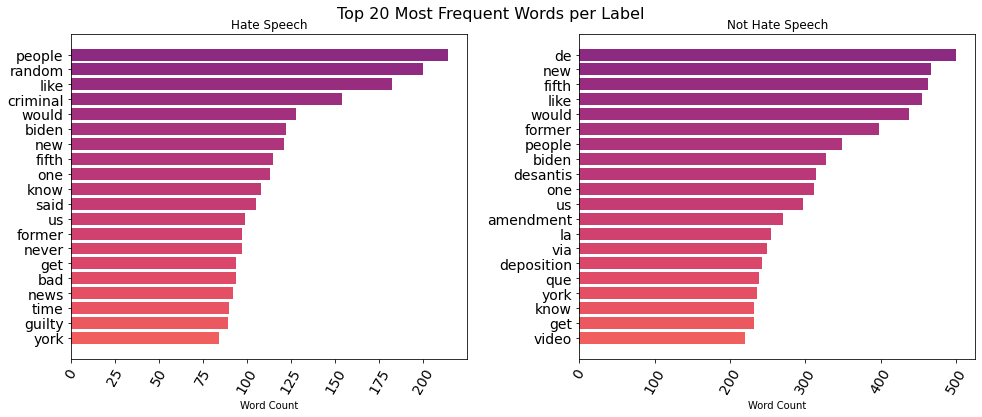

In [288]:
new_figure = plt.figure(figsize=(14,6))

ax = new_figure.add_subplot(121)
ax.invert_yaxis()

ax2 = new_figure.add_subplot(122)
ax2.invert_yaxis()

# generating a bar chart on each axes
ax.barh(hate_bar_words, hate_bar_counts, color=color)
ax2.barh(not_hate_bar_words, not_hate_bar_counts, color=color)

ax.title.set_text('Hate Speech')
ax2.title.set_text('Not Hate Speech')

for ax in new_figure.axes:
    plt.sca(ax)
    plt.xticks(rotation=60, fontsize=14)
    plt.xlabel("Word Count")
    plt.yticks(fontsize=14)
plt.tight_layout(pad=2)

new_figure.suptitle('Top 20 Most Frequent Words per Label', fontsize=16)

plt.show()

# Visualizing Unique Words with Venn Diagram

In [289]:
import matplotlib_venn as venn
from matplotlib_venn import venn2, venn2_circles, venn3, venn3_circles
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Comparison of Unique Words in Each Corpus Label')

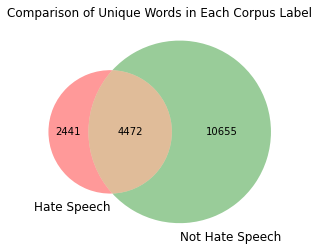

In [290]:
venn2([set(flat_hate), set(flat_not_hate)], set_labels = ('Hate Speech', 'Not Hate Speech'))
plt.title('Comparison of Unique Words in Each Corpus Label')
# plt.savefig('../visualizations/word_venn.png', bbox_inches = "tight", pad_inches=.5)

### Word Clouds

In [291]:
from wordcloud import WordCloud
hate_dict = dict(zip(hate_bar_words, hate_bar_counts))
not_hate_dict = dict(zip(not_hate_bar_words, not_hate_bar_counts))

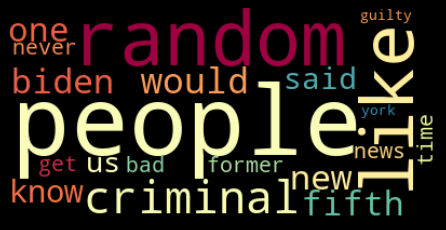

In [292]:
# create the word cloud:
wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(hate_dict)

# Display the generated image w/ matplotlib:
plt.figure(figsize=(6,6), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

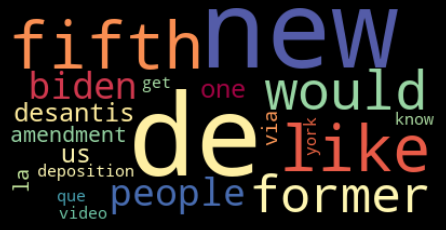

In [293]:
wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(not_hate_dict)

plt.figure(figsize=(6,6), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## Tweet Cloud of Most Frequent Words in Corpus

In [294]:
tweet_df = clean_df[['clean_tweets', 'label']].copy()

In [295]:
tweet_df.to_csv('corpus.txt', sep='\t')

In [296]:
import stylecloud
stylecloud.gen_stylecloud(file_path = 'corpus.txt', icon_name= 'fab fa-twitter', collocations=False, output_name = "icon_cloud.png")

<img src="icon_cloud.png" width="400" height="100">

# Model building

In [297]:
# assigning variables to essential columns
data = clean_df['clean_tweets']
target = clean_df['label']

## Lemmatization

This last method reduces each word into a linguistically valid **lemma**, or **root word**. It does this through linguistic mappings, using the WordNet lexical database.


In [298]:
# creating a list with all lemmatized outputs
lemmatizer = WordNetLemmatizer() 
lemmatized_output = []

for listy in data:
    lemmed = ''.join([lemmatizer.lemmatize(w) for w in listy])
    lemmatized_output.append(lemmed)

In [299]:
X_lem = lemmatized_output
y_lem = target

**Now X_lem and y_lem are contain cleaned text and the original labels, ready to be used for modeling.**

# Feature Engineering

With Natural Language Processing, the purpose of feature engineering is to transform the tokenized text data into numerical vectors that the machine learning algorithm can "understand."

In this notebook, we'll be iterating through three different feature engineering techniques: **Count Vectorization and TF-IDF Vectorization**. Trying out these techniques could yield vastly different metrics on the same four baseline models.

## Train-Test Split
First, let's perform a train-test split of the dataset, where 20% is reserved as unseen testing data.

In [300]:
X_train, X_test, y_train, y_test = train_test_split(X_lem, y_lem, test_size=0.20, random_state=15)

## TF-IDF Vectorization

First, we’ll be trying one of the most popular methods, TF-IDF Vectorization.

This is an acronym that stands for “Term Frequency — Inverse Document” Frequency which are the components of the resulting scores assigned to each word.
- Term Frequency: This summarizes how often a given word appears within a document.
- Inverse Document Frequency: This down scales words that appear a lot across documents.

Without going into the math, TF-IDF are word frequency scores that try to highlight words that are more interesting, e.g. frequent in a document but not across other documents.

In [301]:
# instantiating tf_idf vectorizer
tfidf = TfidfVectorizer(stop_words= stop_words, ngram_range=(1,2))

In [302]:
# transforming tokenized data 
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Modeling Process

## Evaluation Metrics

For this business problem, **we will use F1 score as the main metric**, while also looking at Precision and Recall. The F1 score finds the harmonic mean between Precision and Recall, and it's useful for data with high class imbalance.

**Overall, we want as much hate speech to flagged as possible** and so that it can be efficiently removed. This means also **optomizing the True Positive Rate**,  Recall.

### Weighted F1 Score

We will also be looking at the weighted F1 score, as it **can account for the class imbalance in labels by calculating metrics for each label**. It finds their average weighted by support (the number of true instances for each label). This results in a F1 score that is not between precision and recall.


## Using TF-IDF

## Logistic Regression Model

Logistic Regression is another common model used for classification tasks. Additionally, this model tends to work better with larger datasets.

In [303]:
log_reg = LogisticRegression(penalty='l2', class_weight='balanced', random_state=20)
# class_weight='balanced' actually didn't impact the score

Here I added `class_weight='balanced'` again, but this actually didn't impact the score. So we'll keep that hyperparamter. Also note that the penality is set to `L2`, but that's already the default.

In [304]:
log_reg.fit(X_train_tfidf, y_train)
log_reg_test_preds = log_reg.predict(X_test_tfidf)

In [305]:
log_reg_precision = precision_score(y_test, log_reg_test_preds)
log_reg_recall = recall_score(y_test, log_reg_test_preds)
log_reg_f1_score = f1_score(y_test, log_reg_test_preds)
log_reg_f1_weighted = f1_score(y_test, log_reg_test_preds, average='weighted')

# printing scores
result= {'Performance':['Precision','Recall','F1_score','F1_weighted'],
          'Score':[log_reg_precision,log_reg_recall,log_reg_f1_score,log_reg_f1_weighted]}
pd.DataFrame(result)

,Performance,Score
0,Precision,0.743802
1,Recall,0.775862
2,F1_score,0.759494
3,F1_weighted,0.884391


## Naive Bayes Model

This model is another common baseline classification algorithm that uses Bayes Theorem with an assumption of independence between predictors. However, this assumption of independence is usually violated because the predictors are typically correlated to each other. That's where the "Naive" comes from.

Naive Bayes is a popular choice for text classification because it classifies based on the probabilities of events. Another pro is that this model takes less time to train.

In [306]:
naive_bayes = MultinomialNB(alpha = .01)

In [307]:
%%time
naive_bayes.fit(X_train_tfidf, y_train)
bayes_test_preds = naive_bayes.predict(X_test_tfidf)

CPU times: total: 15.6 ms
Wall time: 11 ms


In [308]:
bayes_precision = precision_score(y_test, bayes_test_preds)
bayes_recall = recall_score(y_test, bayes_test_preds)
bayes_f1_score = f1_score(y_test, bayes_test_preds)
bayes_f1_weighted = f1_score(y_test, bayes_test_preds, average='weighted')

# printing scores
result2= {'Performance':['Precision','Recall','F1_score','F1_weighted'],
          'Score':[bayes_precision,bayes_recall,bayes_f1_score,bayes_f1_weighted]}
pd.DataFrame(result)

,Performance,Score
0,Precision,0.743802
1,Recall,0.775862
2,F1_score,0.759494
3,F1_weighted,0.884391


## Random Forest Model

A random forest model is an ensamble method that uses multiple Decision Trees to try to predict the output variable. Typically, it's one of the best performing models for classification problems.

In [309]:
random_forest = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=0)

Note that adding `class_weight='balanced'` actually increaased precision, but decreased F1. We'll keep that hyperparameter in there, because it would need to be added eventually anyway, to deal with the huge class imbalance in this dataset.

In [310]:
random_forest.fit(X_train_tfidf, y_train)
rf_test_preds = random_forest.predict(X_test_tfidf)

In [311]:
rf_precision = precision_score(y_test, rf_test_preds)
rf_recall = recall_score(y_test, rf_test_preds)
rf_f1_score = f1_score(y_test, rf_test_preds)
rf_f1_weighted = f1_score(y_test, rf_test_preds, average='weighted')

# printing scores
result3= {'Performance':['Precision','Recall','F1_score','F1_weighted'],
          'Score':[rf_precision,rf_recall,rf_f1_score,rf_f1_weighted]}
pd.DataFrame(result)

,Performance,Score
0,Precision,0.743802
1,Recall,0.775862
2,F1_score,0.759494
3,F1_weighted,0.884391


# Evaluating All Models

In [312]:
final = {'Model ':['Logistic regression','Naive(multinomial)','Randomforest'],
        'Precision':[log_reg_precision,bayes_precision,rf_precision],
        'Recall':[log_reg_recall,bayes_recall,rf_recall],
        'F1 score':[log_reg_f1_score,bayes_f1_score,rf_f1_score],
        'F1 weighted':[log_reg_f1_weighted,bayes_f1_weighted,rf_f1_weighted]}
pd.DataFrame(final)

,Model,Precision,Recall,F1 score,F1 weighted
0,Logistic regression,0.743802,0.775862,0.759494,0.884391
1,Naive(multinomial),0.732468,0.607759,0.664311,0.849546
2,Randomforest,0.917266,0.549569,0.687332,0.870133


# Confusion matrix

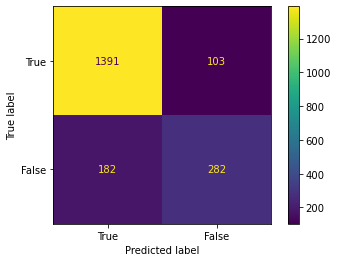

In [313]:
confusion_matrix = metrics.confusion_matrix(y_test, bayes_test_preds)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [True, False])

cm_display.plot()
plt.show()

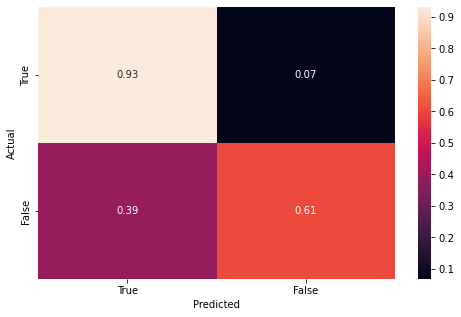

In [314]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, bayes_test_preds)
# Normalise
target_names=['True','False']
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

# Conclusion :

After analysis all three model the **best f1 score and recall value we are getting in logistic regression model**.

**F1 score : 0.75\
recall   : 0.77**

over all we are getting 2441 unique hate speech word in our data set.
This model will help to idetentify hate speech tweet easily.
word like criminal ,fraud, bad and many more are most occuring word in hate speech  in this data set.
